# Delineate basins 1-by-1
This is a working script used to delineate basins using the MERIT Hydro data (DEM, flow direction, basin discretization). CAMELS-US and RHBN metadata about station locations do not always lead to accurate basin delineation. In this script we go through the basins one by one, so that we can manually modify the outlet location in the CAMELS-spat metadata file for basins for which the original station or outlet location is not a good fit with the MERIT DEM. This also lets us add extra notes about the confidence we have in this manually moved outlet and therefore the resulting basin outline. 

In [1]:
import sys
import shutil
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# MERIT Hydro data
merit_path = cs.read_from_config(config_file, 'merit_path')
merit_acc = Path(data_path) / merit_path / 'flow_accumulation_grid' / 'merit_hydro_acc.tif'
merit_dir = Path(data_path) / merit_path / 'flow_direction_grid' / 'merit_hydro_dir.tif'
merit_bas = Path(data_path) / merit_path / 'shapes' / 'basins' / 'cat_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1_hillslopes_pfaf_7_8_clean_fixed.shp'
merit_riv = Path(data_path) / merit_path / 'shapes' / 'rivers' / 'riv_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# CRS to use for area calculations and overlap
crs = cs.read_from_config(config_file, 'equal_area_crs')

### Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Shapefiles
basins_shp = gpd.read_file(merit_bas)
rivers_shp = gpd.read_file(merit_riv)

In [6]:
# Fix up the missing hillslopes
# We are missing out on a single coastal hillslope in northern canada. Chances are we can complete the procedure anyway
arctic_hill_files = [Path(data_path) / merit_path / 'shapes' / 'basins' / 'hillslope_84_clean_fixed.shp',
                     Path(data_path) / merit_path / 'shapes' / 'basins' / 'hillslope_85_clean_fixed.shp']

arctic_hill_84 = gpd.read_file(arctic_hill_files[0])
arctic_hill_85 = gpd.read_file(arctic_hill_files[1])

basins_shp = pd.concat([basins_shp,arctic_hill_84,arctic_hill_85])

### Delineation

In [7]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [8]:
# Make sure we know the correct metadata columns
c_area = np.where(cs_meta.columns == 'Basin_area_km2')[0][0]
c_over = np.where(cs_meta.columns == 'Ref_and_new_shape_fractional_overlap')[0][0]

assert (cs_meta.columns[c_area] == 'Basin_area_km2') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_over] == 'Ref_and_new_shape_fractional_overlap')

In [57]:
def delineation_loop(i,plot=False):
    
    '''Delineates basin for station at index i in the CAMELS-spat metadata file'''
    
    # Input:
    # i - index in CAMELS-spat metadata file to process
    
    # 1. Prepare file paths and names
    # --------------------------------------------------------------------------------------
    basin_id, shp_lump_path, shp_dist_path, ref_path, plot_path = \
                                        cs.prepare_delineation_outputs(cs_meta, i, Path(data_path)/cs_basin_folder)
    print('Now running basin {}. {}'.format(i,basin_id))
    
    # 2. Get the station or outlet location
    # --------------------------------------------------------------------------------------
    #lat,lon = cs.read_delineation_coords(cs_meta,i)
    print('!!! Running with fixed lat/lon coordinates !!!'); lon,lat = -141.19085,64.79407
    
    # 3. Delineate the basin
    # --------------------------------------------------------------------------------------
    # 3a. Subset the Geotiffs for quicker processing
    subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
    temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                                    str(merit_acc), 
                                                    str(merit_dir),
                                                    temp_dir = tmp_dir)
    grid,acc,fdir = cs.load_tifs_with_pysheds(str(temp_acc),str(temp_dir)) 
        
    # 3b. Basin extraction
    # Ignore future warnings for this part of the code to avoid FutureWarning screen spam by Shapely and Pandas
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        # Extract the full basin with pysheds
        lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path) # Saves file as part of function
        lump_basin = cs.add_area_to_shape(lump_basin, column='unitarea', crs=crs)
        
        # Extract the MERIT Hydro basins and river network
        dist_basin, dist_river = cs.subset_merit_hydro_to_basin(basins_shp,rivers_shp,lump_basin,shp_dist_path,
                                                                lat,lon,crs=crs) # Ditto
    
    # 4. Delineation checks
    # --------------------------------------------------------------------------------------
    # 4a. Assert shape validity
    if not all(lump_basin.is_valid): print('ERROR: Lumped shape not valid') # assert() throws SyntaxWarning over .is_valid
    if not all(dist_basin.is_valid): print('ERROR: Distributed shape not valid')
        
    # 4b. Get areas and overlap
    area_lump = (lump_basin.to_crs('ESRI:102008').area / 10**6)[0] # [km^2]
    area_dist = dist_basin['unitarea'].sum() # [km^2]
    overlap_lump = cs.calculate_basin_and_reference_overlap(lump_basin, ref_path, crs=crs) # Returns 'n/a' if no reference shape
    overlap_dist = cs.calculate_basin_and_reference_overlap(dist_basin, ref_path, crs=crs) # Should be identical to lumped
    
    # 4c. Visual assessment of outcomes
    ref_areas = cs.get_reference_areas(cs_meta,i) # [km^2] 
    stats = cs.prepare_plotting_stats(ref_areas,area_lump,area_dist,overlap_lump,overlap_dist) 
    #if plot:
    #    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, stats, plot_path)
    cs.plot_discretization_results(basin_id, lump_basin, dist_basin, dist_river, ref_path, lat, lon, stats, \
                                   plot_path, to_screen=plot)
    
    # 4d. Update metadata file
    cs_meta.iat[i,c_area] = area_dist
    cs_meta.iat[i,c_over] = overlap_dist
    
    return

#### Manual runs

In [58]:
run_this = 963
cs_meta.iloc[run_this].Station_id

'09ED001'

Now running basin 963. CAN_09ED001
!!! Running with fixed lat/lon coordinates !!!


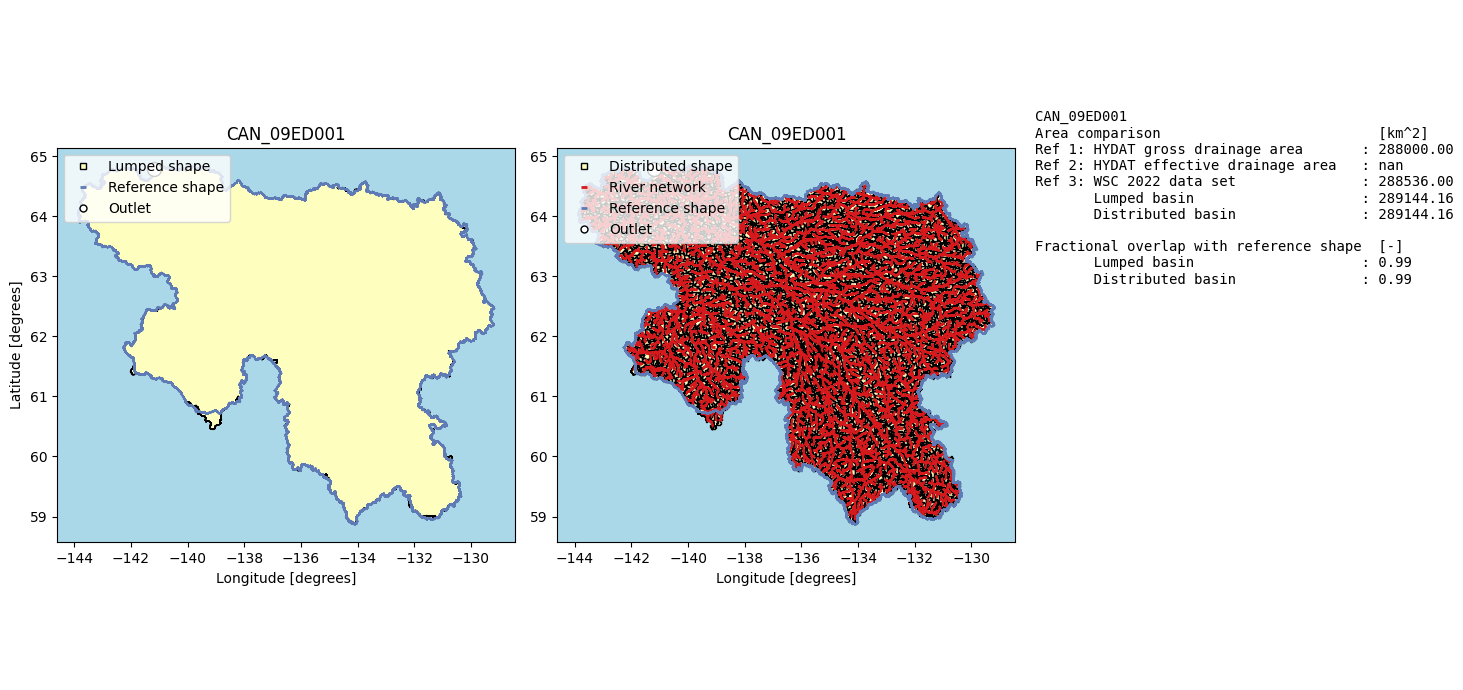

In [59]:
delineation_loop(run_this, plot=True)

#### End manual runs

In [18]:
#for i,_ in cs_meta.iterrows():
for i in range(1017,len(cs_meta)):
    delineation_loop(i)

Now running basin 1017. CAN_10TF001


C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1018. CAN_10UH001
Now running basin 1019. CAN_11AA026
Now running basin 1020. CAN_11AA032
Now running basin 1021. CAN_11AB075
Now running basin 1022. CAN_11AB117
Now running basin 1023. CAN_11AC025
Now running basin 1024. CAN_11AE008
Now running basin 1025. CAN_11AE009
Now running basin 1026. CAN_11AE014
Now running basin 1027. USA_1013500
Now running basin 1028. USA_1022500
Now running basin 1029. USA_1030500
Now running basin 1030. USA_1031500
Now running basin 1031. USA_1047000
Now running basin 1032. USA_1052500
Now running basin 1033. USA_1054200
Now running basin 1034. USA_1055000
Now running basin 1035. USA_1057000
Now running basin 1036. USA_1073000
Now running basin 1037. USA_1078000
Now running basin 1038. USA_1118300
Now running basin 1039. USA_1121000
Now running basin 1040. USA_1123000
Now running basin 1041. USA_1134500
Now running basin 1042. USA_1137500
Now running basin 1043. USA_1139000
Now running basin 1044. USA_1139800
Now running basin 1045. USA_

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\io\file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)


Now running basin 1053. USA_1333000
Now running basin 1054. USA_1350000
Now running basin 1055. USA_1350080
Now running basin 1056. USA_1350140
Now running basin 1057. USA_1365000
Now running basin 1058. USA_1411300
Now running basin 1059. USA_1413500
Now running basin 1060. USA_1414500
Now running basin 1061. USA_1415000
Now running basin 1062. USA_1423000
Now running basin 1063. USA_1434025
Now running basin 1064. USA_1435000
Now running basin 1065. USA_1439500
Now running basin 1066. USA_1440000
Now running basin 1067. USA_1440400
Now running basin 1068. USA_1451800
Now running basin 1069. USA_1466500
Now running basin 1070. USA_1484100
Now running basin 1071. USA_1485500
Now running basin 1072. USA_1486000
Now running basin 1073. USA_1487000
Now running basin 1074. USA_1491000
Now running basin 1075. USA_1510000
Now running basin 1076. USA_1516500
Now running basin 1077. USA_1518862
Now running basin 1078. USA_1532000
Now running basin 1079. USA_1539000
Now running basin 1080. USA_

Now running basin 1281. USA_3604000
Now running basin 1282. USA_4015330
Now running basin 1283. USA_4024430
Now running basin 1284. USA_4027000
Now running basin 1285. USA_4040500
Now running basin 1286. USA_4043050
Now running basin 1287. USA_4045500
Now running basin 1288. USA_4056500
Now running basin 1289. USA_4057510
Now running basin 1290. USA_4057800
Now running basin 1291. USA_4059500
Now running basin 1292. USA_4063700
Now running basin 1293. USA_4074950
Now running basin 1294. USA_4105700
Now running basin 1295. USA_4115265
Now running basin 1296. USA_4122200
Now running basin 1297. USA_4122500
Now running basin 1298. USA_4124000
Now running basin 1299. USA_4127918
Now running basin 1300. USA_4127997
Now running basin 1301. USA_4161580
Now running basin 1302. USA_4185000
Now running basin 1303. USA_4196800
Now running basin 1304. USA_4197100
Now running basin 1305. USA_4197170
Now running basin 1306. USA_4213000
Now running basin 1307. USA_4213075
Now running basin 1308. USA_

Now running basin 1509. USA_8324000
Now running basin 1510. USA_8377900
Now running basin 1511. USA_8378500
Now running basin 1512. USA_8380500
Now running basin 1513. USA_9034900
Now running basin 1514. USA_9035800
Now running basin 1515. USA_9035900
Now running basin 1516. USA_9047700
Now running basin 1517. USA_9065500
Now running basin 1518. USA_9066000
Now running basin 1519. USA_9066200
Now running basin 1520. USA_9066300
Now running basin 1521. USA_9081600
Now running basin 1522. USA_9107000
Now running basin 1523. USA_9210500
Now running basin 1524. USA_9223000
Now running basin 1525. USA_9306242
Now running basin 1526. USA_9312600
Now running basin 1527. USA_9352900
Now running basin 1528. USA_9378170
Now running basin 1529. USA_9378630
Now running basin 1530. USA_9386900
Now running basin 1531. USA_9404450
Now running basin 1532. USA_9430500
Now running basin 1533. USA_9430600
Now running basin 1534. USA_9447800
Now running basin 1535. USA_9480000
Now running basin 1536. USA_

In [19]:
# Remove the temporary directory
shutil.rmtree(tmp_dir)

### Update metadata with confidence ratings

In [155]:
# Add a Delineation_confidence column
# Set the default to high, and update below in cases where we don't like the delineation that MERIT data gives us, but we
#   cannot easily fix this
cs_meta['Delineation_confidence'] = 'high'
cs_meta['Delineation_notes'] = 'n/a'

In [156]:
# Define the notes we want to make
# The will go in a list that we will later integrate into the metadata dataframe
# [country, gauge, confidence, note]
# Confidence:
# - low:    I believe the MERIT DEM is somehow wrong. I'll also asign 'low' if it's not clear if MERIT is wrong, 
#             but difference with reference shape feels too large
# - medium: uncertain to say which DEM (MERIT or whatever was used for the reference shape) is correct
# - high:   I believe the MERIT delineation is OK
# This is based on visual inspection of the MERIT accumulated area GeoTIFF, reference shape, and Google Maps satellite imagery
#  using a threshold of 90% area overlap with reference shape to initiate a manual check
notes = []
notes.append(['CAN','01AL004', 'low',    'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01ED007', 'low',    'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01EE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02AB014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02AB017', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02AC001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02BA003', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of marshland; see 02BB003'])
notes.append(['CAN','02BB003', 'medium', 'Very flat region, MERIT DEM connects part of this basin to another outlet through a region of marshland; see 02BA003'])
notes.append(['CAN','02BF005', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF005', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF007', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF008', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF009', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF012', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02BF013', 'high',   'Part of a series of nested gauges: 02BF005, 02BF006, 02BF013, 02BF007, 02BF008, 02BF009, 02BF012'])
notes.append(['CAN','02CA002', 'low',    'Very flat region, MERIT DEM connects out parts of this basin to other basins by mistakenly identifying roads as rivers'])
notes.append(['CAN','02DD013', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02DD015', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02ED013', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02FA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02FC017', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC010', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC031', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GD019', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GH003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GH003', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB022', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB023', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02LB008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02LB017', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02PA007', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','02PC018', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02PD002', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD004', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD013', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02PD015', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences. Part of a series of nested gauges: 02PD002, 02PD004, 02PD012, 02PD013, 02PD014, 02PD015'])
notes.append(['CAN','02UA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YK005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YK008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02YM004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZD002', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','02ZC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZE004', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','02ZG001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','02ZG004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZH002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZL005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','02ZN002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','03BD002', 'unknown','No reference shape available'])
notes.append(['CAN','03ED001', 'unknown','No reference shape available'])
notes.append(['CAN','04CB001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04EA001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04GB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04JC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04JD005', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04KA001', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','04LJ001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','04MD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05AA008', 'low',    'Difference with reference shape likely explained by DEM not recognizing channel trajectory through a tunnel'])
notes.append(['CAN','05AC030', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05AH047', 'unknown','No reference shape available'])
notes.append(['CAN','05CB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05CG004', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05DA010', 'medium', 'Mountainous region, difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','05DF007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05ED002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05EE006', 'low',    'Very flat region, MERIT DEM divides the reference shape into multiple subbasins with oulets in different directions'])
notes.append(['CAN','05EE009', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05EF005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05FA014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05FC007', 'low',    'Difference with reference shape likely explained by DEM not recognizing channel trajectory through a region of flat terrain'])
notes.append(['CAN','05FE002', 'medium', 'Very flat region, reference shape includes a subbasin that is identified as an endorheic basin in MERIT'])
notes.append(['CAN','05GA008', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05GA010', 'medium', 'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road and due to presence of lakes'])
notes.append(['CAN','05GA012', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05GB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05GC007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05GD002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05HG021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05HH003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JB007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JC004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JC007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JF011', 'medium', 'Very flat region, MERIT DEM divides the reference shape into multiple subbasins with oulets in different directions'])
notes.append(['CAN','05JF014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05JG001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JG013', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JH005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JJ009', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JK008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05JM010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes; also likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05KB003', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KB006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KB011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KC001', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05KE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05KE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05KH007', 'medium', 'Very flat region, reference shape includes subbasins that are identified as endorheic basins in MERIT. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05LA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB006', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05LB008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LB010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LD001', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05LE011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05LJ027', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05LL014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05LL015', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05MA020', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MA021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MA025', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land. Part of a series of nested gauges: 05KB003, 05KB006, 05KB011, 05KC001, 05KH007, 05MA025'])
notes.append(['CAN','05MC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MC003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MD010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05ME005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05ME007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MG001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MG003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05MH006', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','05MH007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05MH008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05NB033', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NB035', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05ND011', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NE003', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05NF002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NF006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NF008', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05NF010', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road'])
notes.append(['CAN','05NG010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NG012', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05NG020', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OB016', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OB021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes and  built-up areas'])
notes.append(['CAN','05OC016', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05OC019', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05OC022', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OE009', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OE010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OF009', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes and roads'])
notes.append(['CAN','05OF014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OF017', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OF018', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a road as a channel'])
notes.append(['CAN','05OF020', 'low',    'Very flat region, difference with reference shape due to DEM (mistakenly?) connecting rivers across a road instead of identifying the correct channel'])
notes.append(['CAN','05OH007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences partly due to the presence of roads'])
notes.append(['CAN','05OJ008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','05OJ016', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to the presence of roads'])
notes.append(['CAN','05OJ017', 'medium', 'Very flat region, difference with reference shape likely partly explained by DEM differences due to presence of  built-up areas'])
notes.append(['CAN','05QA004', 'low',    'Very flat region, difference with reference shape likely partly explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05RA001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05RB003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05RE002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05SC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05SD003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','05UA003', 'medium', 'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05UF004', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','05UH001', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','06AD008', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07AA007', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AF010', 'high',   'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AG003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07AH001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07AH002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07BA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07BB014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences. MERIT river network does not pass through station location'])
notes.append(['CAN','07BC006', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07BE003', 'low',    'Very flat region, MERIT DEM does not have a stream near this station and also connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','07BE004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Very large difference with reference shape'])
notes.append(['CAN','07BF002', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07BJ001', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07BK005', 'low',    'Very flat region, difference with reference shape due to DEM mistakenly connecting rivers across a road instead of identifying the correct channel. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','07CA003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CA005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CA006', 'low',    'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying channels in 2 subbasins as land'])
notes.append(['CAN','07CA008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07CD004', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07CE003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07DA018', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07DB001', 'medium', 'Very flat region, difference with reference shape likely (?) explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07EC003', 'unknown','No reference shape available'])
notes.append(['CAN','07FD013', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07GE003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','07GE007', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07GH004', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['CAN','07HB001', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07HC002', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07JA003', 'medium', 'Very flat region, difference with reference shape partly due to DEM misidentifying the correct channel as land and also presence of lakes/potholes'])
notes.append(['CAN','07JC001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07JC002', 'low',    'Very flat region, difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','07LB002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07OB006', 'low',    'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes. Large difference with reference shape'])
notes.append(['CAN','07SA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','07SC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes/potholes'])
notes.append(['CAN','08EE012', 'low',    'Moved gauge to correct DEM adding another subbasin to this outlet due to misidentifying the correct channel as land. Note that this leads to only relatively small differences with reference shape'])
notes.append(['CAN','08EE025', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HA016', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of built-up areas'])
notes.append(['CAN','08HA068', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HB048', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08HB075', 'low',    'Difference with reference shape likely explained by DEM differences due to presence of trees. Large difference with reference shape'])
notes.append(['CAN','08HF004', 'low',    'Difference with reference shape likely explained by DEM connecting another subbasin to this outlet due to misidentifying a channel as land. See 08HF005'])
notes.append(['CAN','08HF005', 'low',    'Difference with reference shape likely explained by DEM disconnecting another subbasin to this outlet due to misidentifying a channel as land. See 08HF004'])
notes.append(['CAN','08JD006', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','08JE004', 'low',    'Difference with reference shape likely explained by DEM connecting another subbasin to this outlet through a region with trees'])
notes.append(['CAN','08LE108', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08LG056', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08MH029', 'medium', 'Flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NE008', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','08NE077', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NG076', 'low',    'Difference with reference shape likely explained by DEM differences. Large difference with reference shape'])
notes.append(['CAN','08NJ130', 'medium', 'Difference with reference shape likely explained by DEM differences due to presence of trees'])
notes.append(['CAN','08NM134', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NM173', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08NM242', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08OA003', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','08OB002', 'medium', 'Difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','09AC007', 'medium', 'MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','10AA004', 'medium', 'MERIT DEM connects another subbasin to this outlet through a region of flat terrain'])
notes.append(['CAN','10ED007', 'low',    'Difference with reference shape likely explained by DEM misidentifying a channel as land'])
notes.append(['CAN','10ED009', 'medium', 'Difference with reference shape likely explained by DEM differences'])




In [157]:
# Ensure we have the correct column IDs
c_note, c_conf = 23,22
assert (cs_meta.columns[c_note] == 'Delineation_notes') # If these aren't true, they'll pop an error
assert (cs_meta.columns[c_conf] == 'Delineation_confidence')

In [158]:
# Apply the changes to the metadata file
for note in notes:
    
    country = note[0]
    station = note[1]
    confidence = note[2]
    remarks = note[3]
    
    idx = cs_meta.index[(cs_meta['Country'] == country) & (cs_meta['Station_id'] == station)][0] # There can be only one
    
    cs_meta.iat[idx,c_note] = remarks
    cs_meta.iat[idx,c_conf] = confidence

In [37]:
# Save the metadata file
cs_meta.to_csv(cs_meta_path / cs_meta_name, encoding='utf-8', index=False)

In [160]:
cs_meta

,Country,Station_id,Station_name,Station_lat,Station_lon,Station_source,Outlet_lat,Outlet_lon,Outlet_source,Manual_lat,...,Ref_area_1_km2,Ref_area_2_src,Ref_area_2_km2,Ref_shape,Ref_shape_source,Ref_shape_area_km2,Manual_delineation_notes,Ref_and_new_shape_fractional_overlap,Delineation_confidence,Delineation_notes
0,CAN,01AD002,SAINT JOHN RIVER AT FORT KENT,47.25806,-68.59583,WSC 20222 data set,47.257877,-68.594919,WSC 20222 data set,47.2577,...,14700.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,14677.400000,moved outlet to middle of wide river,0.993792,high,n/a
1,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,47.20661,-68.95694,WSC 20222 data set,47.206016,-68.956727,WSC 20222 data set,-999.0000,...,1350.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,1348.300000,NaN,0.985513,high,n/a
2,CAN,01AE001,FISH RIVER NEAR FORT KENT,47.23750,-68.58278,WSC 20222 data set,47.237438,-68.581991,WSC 20222 data set,-999.0000,...,2260.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,2238.950000,NaN,0.979374,high,n/a
3,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,47.24697,-67.92128,WSC 20222 data set,47.246908,-67.921271,WSC 20222 data set,-999.0000,...,339.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,325.196000,NaN,0.977787,high,n/a
4,CAN,01AF009,IROQUOIS RIVER AT MOULIN MORNEAULT,47.45783,-68.35683,WSC 20222 data set,47.457622,-68.356710,WSC 20222 data set,-999.0000,...,182.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,183.430000,NaN,0.986569,high,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,USA,14309500,"WEST FORK COW CREEK NEAR GLENDALE, OR",42.80400,-123.61091,CAMELS-US,-999.000000,-999.000000,NaN,-999.0000,...,224.92,Geospatial fabric area,226.31,yes,CAMELS-US data set (HCDN),226.314346,NaN,NaN,high,n/a
1694,USA,14316700,"STEAMBOAT CREEK NEAR GLIDE, OR",43.34984,-122.72894,CAMELS-US,-999.000000,-999.000000,NaN,-999.0000,...,587.90,Geospatial fabric area,588.01,yes,CAMELS-US data set (HCDN),588.025033,NaN,NaN,high,n/a
1695,USA,14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.89150,-124.07065,CAMELS-US,-999.000000,-999.000000,NaN,-999.0000,...,443.07,Geospatial fabric area,444.92,yes,CAMELS-US data set (HCDN),444.925651,NaN,NaN,high,n/a
1696,USA,14362250,"STAR GULCH NEAR RUCH, OR.",42.15401,-123.07532,CAMELS-US,-999.000000,-999.000000,NaN,-999.0000,...,41.42,Geospatial fabric area,43.88,yes,CAMELS-US data set (HCDN),43.877901,NaN,NaN,high,n/a


### Backup

In [ ]:
# Define the notes we want to make
# The will go in a list that we will later integrate into the metadata dataframe
# [country, gauge, confidence, note]
notes = []
notes.append(['CAN','01AL004', 'low', 'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01ED007', 'low', 'Very flat region, DEM accuracy is debatable due to potholes'])
notes.append(['CAN','01EE005', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02AB014', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes'])
notes.append(['CAN','02AB017', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes'])
notes.append(['CAN','02AC001', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02BA003', 'medium', 'Very flat region, MERIT DEM connects another subbasin to this outlet through a region of marshland; see 02BB003'])
notes.append(['CAN','02BB003', 'medium', 'Very flat region, MERIT DEM connects part of this basin to another outlet through a region of marshland; see 02BA003'])
notes.append(['CAN','02CA002', 'low', 'Very flat region, MERIT DEM connects out parts of this basin to other basins by mistakenly identifying roads as rivers'])
notes.append(['CAN','02CB003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes'])
notes.append(['CAN','02DD013', 'medium', 'Very flat region, difference with reference shape likely explained by DEM mistakenly connecting rivers across a road'])
notes.append(['CAN','02DD015', 'low', 'Very flat region, difference with reference shape likely explained by DEM mistakenly connecting rivers across a road'])
notes.append(['CAN','02EC002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences due to presence of lakes'])
notes.append(['CAN','02FA002', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC010', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC021', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GC031', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GD019', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02GH003', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB022', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02HB023', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])
notes.append(['CAN','02LB008', 'medium', 'Very flat region, difference with reference shape likely explained by DEM differences'])



